In [1]:
%load_ext autoreload
%autoreload 2

# Data


In [2]:
from thesis_work.data import load_data_splits

train_df, valid_df, test_df = load_data_splits(protein_type="kinase")

print(train_df.shape, valid_df.shape, test_df.shape)

Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/ilker/Documents/MyRepos/thesis-work/.venv/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


(53047, 2) (6631, 2) (6631, 2)


## KFold


In [2]:
from thesis_work.cv.split import create_folds, get_kfold_experiment_indices


length = 50
fold_list = create_folds(length=length)
fold_list

[[17, 8, 34, 3, 31, 12, 28, 20, 2],
 [15, 1, 41, 49, 47, 40, 36, 22, 43],
 [14, 0, 24, 16, 45, 9, 27, 38],
 [46, 5, 39, 21, 32, 37, 29, 4],
 [19, 23, 30, 25, 13, 42, 26, 10],
 [7, 11, 18, 44, 48, 33, 35, 6]]

In [12]:
experiment_indices = get_kfold_experiment_indices(length=length)

for experiment_index in experiment_indices:
    train_df, valid_df, test_df = experiment_index
    print(train_df, valid_df, test_df)

[15, 1, 41, 49, 47, 40, 36, 22, 43, 14, 0, 24, 16, 45, 9, 27, 38, 46, 5, 39, 21, 32, 37, 29, 4, 19, 23, 30, 25, 13, 42, 26, 10] [17, 8, 34, 3, 31, 12, 28, 20, 2] [7, 11, 18, 44, 48, 33, 35, 6]
[17, 8, 34, 3, 31, 12, 28, 20, 2, 14, 0, 24, 16, 45, 9, 27, 38, 46, 5, 39, 21, 32, 37, 29, 4, 19, 23, 30, 25, 13, 42, 26, 10] [15, 1, 41, 49, 47, 40, 36, 22, 43] [7, 11, 18, 44, 48, 33, 35, 6]
[17, 8, 34, 3, 31, 12, 28, 20, 2, 15, 1, 41, 49, 47, 40, 36, 22, 43, 46, 5, 39, 21, 32, 37, 29, 4, 19, 23, 30, 25, 13, 42, 26, 10] [14, 0, 24, 16, 45, 9, 27, 38] [7, 11, 18, 44, 48, 33, 35, 6]
[17, 8, 34, 3, 31, 12, 28, 20, 2, 15, 1, 41, 49, 47, 40, 36, 22, 43, 14, 0, 24, 16, 45, 9, 27, 38, 19, 23, 30, 25, 13, 42, 26, 10] [46, 5, 39, 21, 32, 37, 29, 4] [7, 11, 18, 44, 48, 33, 35, 6]
[17, 8, 34, 3, 31, 12, 28, 20, 2, 15, 1, 41, 49, 47, 40, 36, 22, 43, 14, 0, 24, 16, 45, 9, 27, 38, 46, 5, 39, 21, 32, 37, 29, 4] [19, 23, 30, 25, 13, 42, 26, 10] [7, 11, 18, 44, 48, 33, 35, 6]


In [9]:
import numpy as np
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=False)

# data = np.arange(50)
data = [item for sublist in fold_list[:5] for item in sublist]
data = np.array(data)

for train, test in kfold.split(data):
    print("train: %s, test: %s" % (data[train], data[test]))

train: [15  1 41 49 47 40 36 22 43 14  0 24 16 45  9 27 38 46  5 39 21 32 37 29
  4 19 23 30 25 13 42 26 10], test: [17  8 34  3 31 12 28 20  2]
train: [17  8 34  3 31 12 28 20  2 14  0 24 16 45  9 27 38 46  5 39 21 32 37 29
  4 19 23 30 25 13 42 26 10], test: [15  1 41 49 47 40 36 22 43]
train: [17  8 34  3 31 12 28 20  2 15  1 41 49 47 40 36 22 43 46  5 39 21 32 37
 29  4 19 23 30 25 13 42 26 10], test: [14  0 24 16 45  9 27 38]
train: [17  8 34  3 31 12 28 20  2 15  1 41 49 47 40 36 22 43 14  0 24 16 45  9
 27 38 19 23 30 25 13 42 26 10], test: [46  5 39 21 32 37 29  4]
train: [17  8 34  3 31 12 28 20  2 15  1 41 49 47 40 36 22 43 14  0 24 16 45  9
 27 38 46  5 39 21 32 37 29  4], test: [19 23 30 25 13 42 26 10]


# Model


In [2]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from thesis_work.chemberta.utils import get_model


model_type = "DeepChem/ChemBERTa-77M-MLM"
# model: ClassificationModel = get_model(model_type=model_type)

model_args = ClassificationArgs(
    evaluate_each_epoch=True,
    evaluate_during_training_verbose=True,
    no_save=True,
    num_train_epochs=10,
    # overwrite_output_dir=True,
    # auto_weights=True, # NOTE: Not working
    # NOTE: Necessary for training outside of Colab
    use_multiprocessing=False,
    # dataloader_num_workers=0,
    # process_count=1,
    use_multiprocessing_for_evaluation=False,
)

model_args_dict = {"output_hidden_states": True}

model = ClassificationModel(
    model_type="roberta",
    model_name=model_type,
    # args=model_args,
    args=model_args_dict,
    # use_cuda=False,
)

Some weights of the model checkpoint at DeepChem/ChemBERTa-77M-MLM were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['classifier.out_proj.weight', 'classifier.out

In [4]:
model.__dict__

{'args': ClassificationArgs(adafactor_beta1=None, adafactor_clip_threshold=1.0, adafactor_decay_rate=-0.8, adafactor_eps=(1e-30, 0.001), adafactor_relative_step=True, adafactor_scale_parameter=True, adafactor_warmup_init=True, adam_betas=(0.9, 0.999), adam_epsilon=1e-08, best_model_dir='outputs/best_model', cache_dir='cache_dir/', config={}, cosine_schedule_num_cycles=0.5, custom_layer_parameters=[], custom_parameter_groups=[], dataloader_num_workers=0, do_lower_case=False, dynamic_quantize=False, early_stopping_consider_epochs=False, early_stopping_delta=0, early_stopping_metric='eval_loss', early_stopping_metric_minimize=True, early_stopping_patience=3, encoding=None, eval_batch_size=8, evaluate_during_training=False, evaluate_during_training_silent=True, evaluate_during_training_steps=2000, evaluate_during_training_verbose=True, evaluate_each_epoch=True, fp16=True, gradient_accumulation_steps=1, learning_rate=4e-05, local_rank=-1, logging_steps=50, loss_type=None, loss_args={}, manu

## Silhouette samples


In [ ]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=4,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=1,
)

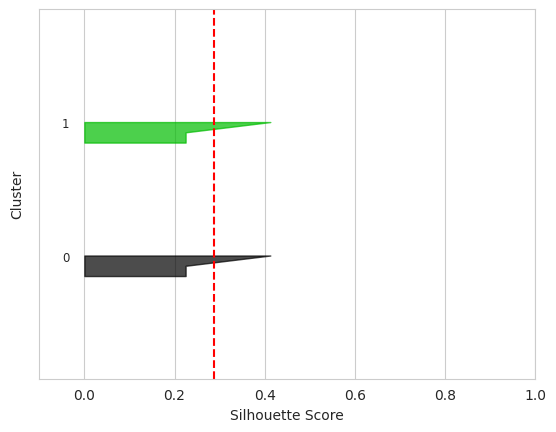

In [8]:
from thesis_work.clustering.evaluation import silhouette_samples_plot

import numpy as np

X = np.array([[1, 2], [1, 4], [1, 0], [4, 2], [4, 4], [4, 0]], dtype=np.float32)
cluster_labels = np.array([0, 0, 0, 1, 1, 1])

silhouette_samples_plot(X, cluster_labels, device="cpu")

## Agglomerative cudaErrorInvalidValue:invalid argument

- Github issue: https://github.com/rapidsai/cuml/issues/4424


In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import cudf
import cupy
from cuml.cluster import AgglomerativeClustering
from cuml.datasets import make_blobs

In [3]:
n_samples = 300_000
n_features = 16

n_clusters = 10
random_state = 0

device_data, device_labels = make_blobs(
    n_samples=n_samples,
    n_features=n_features,
    centers=n_clusters,
    random_state=random_state,
    cluster_std=0.1,
)

device_data = cudf.DataFrame(device_data)
device_labels = cudf.Series(device_labels)

for n_clusters in range(10, 1000, 20):
    hc_cuml = AgglomerativeClustering(
        n_clusters=n_clusters,
        affinity="euclidean",
        linkage="single",
        connectivity="knn",
        n_neighbors=10,
    )
    hc_cuml.fit(device_data)

## RFC

- Link: https://github.com/rapidsai/cuml/issues/3568


In [2]:
import numpy as np
from cuml.ensemble import RandomForestClassifier as cuRFC

X = np.random.normal(size=(300_000, 16)).astype(np.float32)
y = np.asarray([0, 1] * 150_000, dtype=np.int32)

cuml_model = cuRFC()
cuml_model.fit(X, y)
cuml_predict = cuml_model.predict(X)

print("Predicted labels : ", cuml_predict)

Predicted labels :  [0. 1. 0. ... 1. 0. 1.]


In [4]:
import cuml
import numpy as np
from scipy import sparse

m = 25_000
n = 20
density = 0.025
mn = int(density * m * n)
row = np.random.randint(low=0, high=m, size=mn, dtype="int32")
col = np.random.randint(low=0, high=n, size=mn, dtype="int32")
data = np.random.rand(mn).astype("float32")
x = sparse.coo_matrix((data, (row, col)), shape=(m, n))
x = sparse.csr_matrix(x)
umap = cuml.UMAP()
umap.fit(x)

UMAP()

## Find which GPU is working


In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [ ]:
import torch

# allocate some memory on the GPU
device = torch.device("cuda")
x = torch.randn(1024, 1024, device=device)

# run a simple matrix multiplication benchmark
for size in [128, 256, 512, 1024]:
    a = torch.randn(size, size, device=device)
    b = torch.randn(size, size, device=device)
    torch.cuda.synchronize()
    %timeit torch.matmul(a, b)
    torch.cuda.synchronize()


## Clustering visualization for Thesis Method


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# Generate example data
X, y = make_blobs(n_samples=80, centers=4, n_features=2, random_state=7)

# Fit KMeans clustering model
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X)

# Create a figure with two subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))

# Plot the original data on the left subplot
axs[0].scatter(X[:, 0], X[:, 1])
axs[0].set_title("Original Data")
axs[0].spines["right"].set_visible(False)
axs[0].spines["top"].set_visible(False)

# Plot the clustered data on the right subplot
axs[1].scatter(X[:, 0], X[:, 1], c=kmeans.labels_)
axs[1].set_title("Clustered Data")
axs[1].spines["right"].set_visible(False)
axs[1].spines["top"].set_visible(False)

# Plot a circle around each cluster center
for i in range(kmeans.n_clusters):
    circle = plt.Circle(
        (kmeans.cluster_centers_[i, 0], kmeans.cluster_centers_[i, 1]),
        2.6,
        color="red",  # changed color to red
        fill=False,
        linestyle="--",
        linewidth=2.5,
    )
    axs[1].add_artist(circle)

axs[0].xaxis.set_ticklabels([])
axs[0].yaxis.set_ticklabels([])
axs[1].xaxis.set_ticklabels([])
axs[1].yaxis.set_ticklabels([])

plt.savefig("clustered_data.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

## GPU vs CPU

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("cpu_gpu.csv")

In [81]:
df

,molecule_number,GPU - _step,GPU - _step__MIN,GPU - _step__MAX,GPU - running_time,GPU - running_time__MIN,GPU - running_time__MAX,CPU - _step,CPU - _step__MIN,CPU - _step__MAX,CPU - running_time,CPU - running_time__MIN,CPU - running_time__MAX
0,100,1,1,1,2.463027,2.463027,2.463027,1,1,1,2.571459,2.571459,2.571459
1,200,3,3,3,0.472589,0.472589,0.472589,3,3,3,0.873884,0.873884,0.873884
2,500,5,5,5,0.653642,0.653642,0.653642,5,5,5,1.391294,1.391294,1.391294
3,1000,7,7,7,0.664935,0.664935,0.664935,7,7,7,2.008218,2.008218,2.008218
4,5000,9,9,9,1.681390,1.681390,1.681390,9,9,9,8.441650,8.441650,8.441650
5,10000,11,11,11,2.956800,2.956800,2.956800,11,11,11,17.622360,17.622360,17.622360
6,20000,13,13,13,5.277358,5.277358,5.277358,13,13,13,35.387725,35.387725,35.387725


In [82]:
df = df[["molecule_number", "GPU - running_time", "CPU - running_time"]]

In [86]:
df

,molecule_number,GPU - running_time,CPU - running_time
0,100,2.463027,2.571459
1,200,0.472589,0.873884
2,500,0.653642,1.391294
3,1000,0.664935,2.008218
4,5000,1.681390,8.441650
5,10000,2.956800,17.622360
6,20000,5.277358,35.387725


In [88]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Create the original dataframe
data = {'molecule_number': [100, 200, 500, 1000, 5000, 10000, 20000],
        'GPU - running_time': [2.463027, 0.472589, 0.653642, 0.664935, 1.681390, 2.956800, 5.277358],
        'CPU - running_time': [2.571459, 0.873884, 1.391294, 2.008218, 8.441650, 17.622360, 35.387725]}
df = pd.DataFrame(data)

# Fit linear regression models for GPU and CPU running times
gpu_model = LinearRegression().fit(df[['molecule_number']], df['GPU - running_time'])
cpu_model = LinearRegression().fit(df[['molecule_number']], df['CPU - running_time'])

# Predict the GPU and CPU running times for the new rows
new_data = {'molecule_number': [40000, 80000],
            'GPU - running_time': gpu_model.predict([[40000], [80000]]),
            'CPU - running_time': cpu_model.predict([[40000], [80000]])}
new_df = pd.DataFrame(new_data)

# Concatenate the original and new dataframes
df = pd.concat([df, new_df], ignore_index=True)

# Sort the dataframe by molecule_number
df = df.sort_values('molecule_number')

# Print the resulting dataframe
print(df)

   molecule_number  GPU - running_time  CPU - running_time
0              100            2.463027            2.571459
1              200            0.472589            0.873884
2              500            0.653642            1.391294
3             1000            0.664935            2.008218
4             5000            1.681390            8.441650
5            10000            2.956800           17.622360
6            20000            5.277358           35.387725
7            40000            9.368947           69.284446
8            80000           17.825015          137.819730


/thesis-work/.venv/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/thesis-work/.venv/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [89]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Create the original dataframe
data = {'molecule_number': [100, 200, 500, 1000, 5000, 10000, 20000],
        'GPU - running_time': [0.273535, 0.472589, 0.653642, 0.664935, 1.681390, 2.956800, 5.277358],
        'CPU - running_time': [0.571459, 0.873884, 1.391294, 2.008218, 8.441650, 17.622360, 35.387725]}
df = pd.DataFrame(data)

# Fit linear regression models for GPU and CPU running times
gpu_model = LinearRegression().fit(df[['molecule_number']], df['GPU - running_time'])
cpu_model = LinearRegression().fit(df[['molecule_number']], df['CPU - running_time'])

# Predict the GPU and CPU running times for the new rows
new_data = {'molecule_number': [40000, 80000],
            'GPU - running_time': gpu_model.predict([[40000], [80000]]),
            'CPU - running_time': cpu_model.predict([[40000], [80000]])}
new_df = pd.DataFrame(new_data)

# Concatenate the original and new dataframes
df = pd.concat([df, new_df], ignore_index=True)

# Sort the dataframe by molecule_number
df = df.sort_values('molecule_number')

# Print the resulting dataframe
print(df)

   molecule_number  GPU - running_time  CPU - running_time
0              100            0.273535            0.571459
1              200            0.472589            0.873884
2              500            0.653642            1.391294
3             1000            0.664935            2.008218
4             5000            1.681390            8.441650
5            10000            2.956800           17.622360
6            20000            5.277358           35.387725
7            40000           10.234817           70.075377
8            80000           20.047887          139.850221


/thesis-work/.venv/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/thesis-work/.venv/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


<Axes: xlabel='molecule_number'>

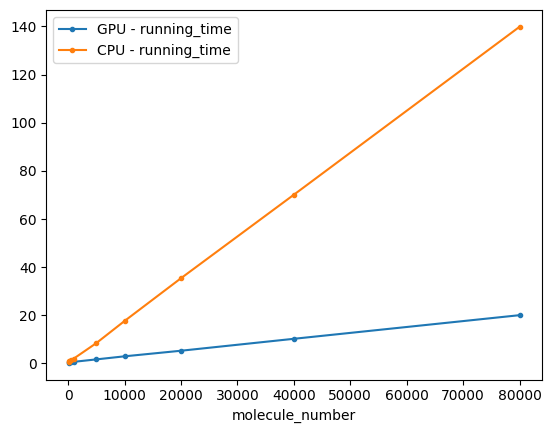

In [90]:
# Plot df by molecule_number
df.plot(x='molecule_number', y=['GPU - running_time', 'CPU - running_time'], style='.-')

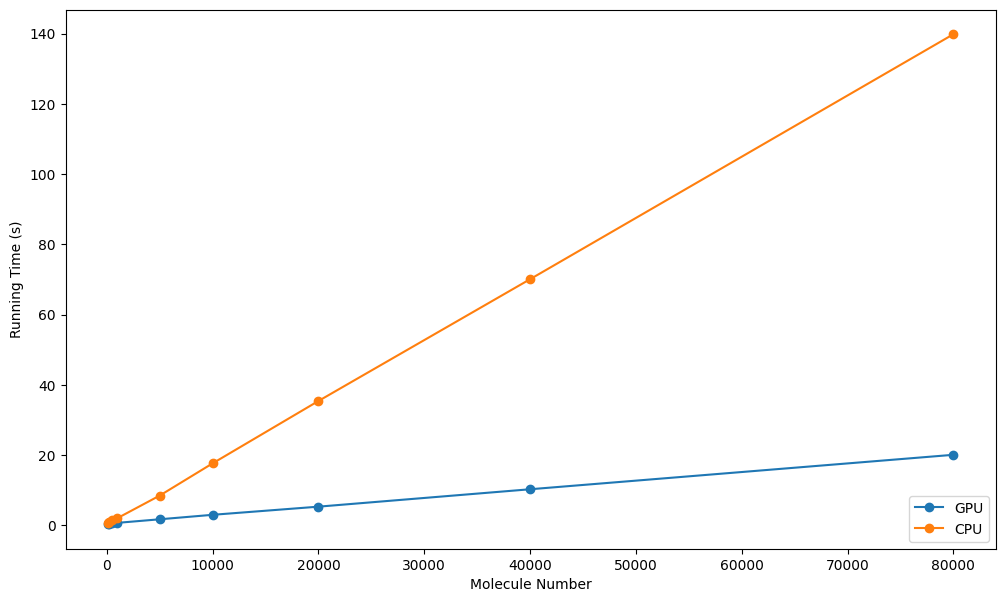

In [109]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))

# Plot the graph
plt.plot(df['molecule_number'], df['GPU - running_time'], label='GPU', marker='o')
plt.plot(df['molecule_number'], df['CPU - running_time'], label='CPU', marker='o')


# Add labels and legend
plt.xlabel('Molecule Number')
plt.ylabel('Running Time (s)')
plt.legend(loc="lower right")

# Save fig
plt.savefig("cpu_gpu.png", dpi=200, bbox_inches="tight")

# Show the plot
plt.show()